In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d serenaraju/yawn-eye-dataset-new

Dataset URL: https://www.kaggle.com/datasets/serenaraju/yawn-eye-dataset-new
License(s): unknown
 95% 153M/161M [00:02<00:00, 94.4MB/s]
100% 161M/161M [00:02<00:00, 78.9MB/s]


In [4]:



# Install necessary libraries
!pip install tensorflow scikit-learn

import tensorflow as tf
from tensorflow.keras import models, layers, applications
import matplotlib.pyplot as plt
from IPython.display import HTML
import zipfile
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 10

In [5]:
# Unzip the dataset
zip_ref = zipfile.ZipFile('/content/yawn-eye-dataset-new.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [8]:

# Helper function to load the dataset from the given directory
def load_dataset(directory):
    return tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        seed=123,
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )


In [9]:
# Load datasets
train_ds = load_dataset("/content/dataset_new/train")
val_ds = load_dataset("/content/dataset_new/test")
# Class names
class_names = train_ds.class_names
print(class_names)

Found 2467 files belonging to 4 classes.
Found 433 files belonging to 4 classes.
['Closed', 'Open', 'no_yawn', 'yawn']


In [10]:
# Calculate class weights
class_counts = np.array([len(list(train_ds.class_names)) for i in range(len(class_names))])
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_names), y=class_names)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Preprocessing layers
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255),
])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2),
])

# Prepare datasets
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# Apply data augmentation to training data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y)).prefetch(buffer_size=AUTOTUNE)

# Model architecture using transfer learning
base_model = applications.MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    resize_and_rescale,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax'),
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
model.summary()

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    class_weight=class_weights,
    verbose=1,
    epochs=EPOCHS,
)


9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (32, 1280)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (32, 128)                 163968    
                                                                 
 dropout (Dropout)           (32, 128)                 0         
                                                         

14/14 [==============================] - 1s 52ms/step - loss: 0.2790 - accuracy: 0.8476
Test Accuracy: 0.8475750684738159


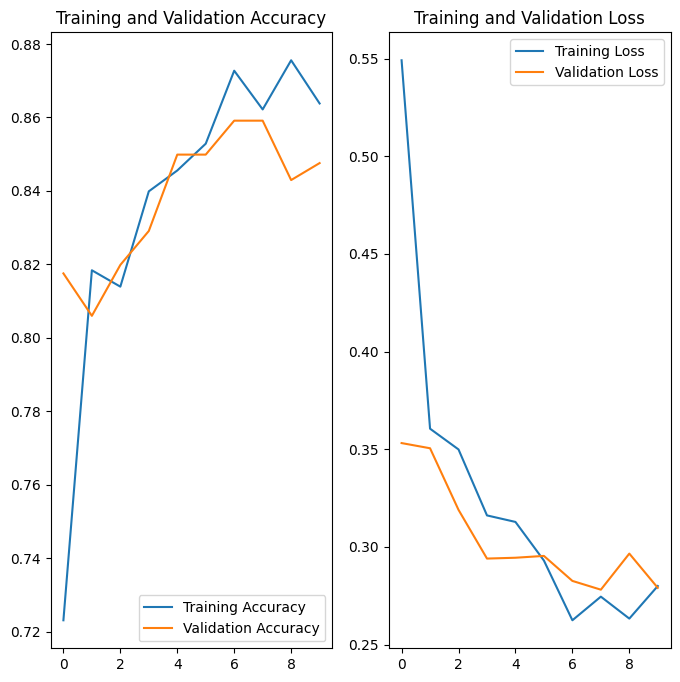

In [11]:
# Evaluate the model
scores = model.evaluate(val_ds)
print(f"Test Accuracy: {scores[1]}")

# Plot training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First image to predict
Actual label: yawn
1/1 [==============================] - 0s 32ms/step
Predicted label: yawn


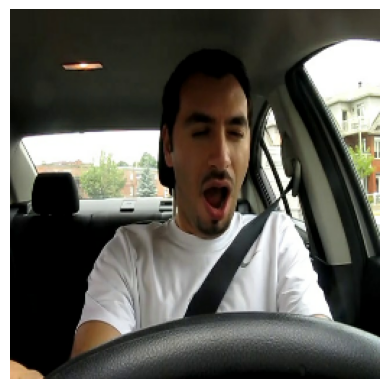

In [17]:
# Function to make predictions on a random image from the test data
def predict_random_image():
    # Shuffle the test dataset to get a random image each time
    shuffled_test_ds = val_ds.shuffle(buffer_size=1000)

    for images_batch, labels_batch in shuffled_test_ds.take(1):
        first_image = images_batch[0].numpy().astype('uint8')
        first_label = labels_batch[0].numpy()

        print("First image to predict")
        plt.imshow(first_image)
        plt.axis('off')
        print("Actual label:", class_names[first_label])

        batch_prediction = model.predict(images_batch)
        print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
predict_random_image()